# Table of Contents
# Table of Contents

1. [Description of the problem and data](#description-of-the-problem-and-data)
2. [Utils section](#utils-section)
3. [Exploratory Data Analysis(EDA) - Inspect, visualize and clean the data](#exploratory-data-analysiseda---inspect-visualize-and-clean-the-data)
4. [DModel Architecture and Data cleaning](#dmodel-architecture-and-data-cleaning)
5. [Split the Data](#split-the-data)
6. [Build the different models](#build-the-different-models)
7. [Compile the different models](#compile-the-different-models)
8. [Train the simple model](#train-the-simple-model)
9. [Train the complex model](#train-the-complex-model)
10. [Result and Analysis](#result-and-analysis)
    - [Running the model with the testing data](#running-the-model-with-the-testing-data)
    - [Analysis of the Plots and Figures](#analysis-of-the-plots-and-figures)
11. [Conclusion](#conclusion)
12. [Links](#links)

# Description of the problem and data

In this competition/assignment, I am creating an RNN based machine learning model to be able to classify if tweets are referring to a real disaster or not. The data from this competition is real twitter data that contains an ID specific for each tweet, the tweet text, and the optional fields of a keyword from the tweet as well as location information. My model will predict whether the test data tweets are referring to a real disaster or not. A positive label (1) indicates that the tweet is referring to a real disaster whereas a negative label (0) indicates the model does not predict the tweet is referring to a real disaster. A model like this could allow government and organizations to mobilize to save lifes and mitigate side effects of a real disaster by detecting if a disaster is happening by monitoring social media feeds in real time and classifying the textual information as disaster related vs not. An uptick in disaster related information being detected in social media could be a call for the government/organization to mobilize to prevent further loss of life and property.

# Utils section

In [1]:
# import all necessary libraries
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
import random

print(keras.__version__)
print(f"Backend: {keras.backend.backend()}") # Should print 'torch'

#Check for GPU availability as well
print("PyTorch version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
    print("GPU Name:", torch.cuda.get_device_name(0))

# load the train_labels.csv file to see data structure and plot distribution of labels
df_train_labels = pd.read_csv("train.csv")
# replace all nan values with something I can identify more easily
df_train_labels.fillna('missing', inplace=True)

# do the same for the test labels
df_test_labels = pd.read_csv("test.csv")
df_test_labels.fillna('missing', inplace=True)

# Get a random positive and a random negative label
rand_pos_set = df_train_labels[df_train_labels.target == 1]
rand_pos = rand_pos_set.iloc[random.randint(0, rand_pos_set.shape[0]), :]
rand_neg_set = df_train_labels[df_train_labels.target == 0]
rand_neg = rand_neg_set.iloc[random.randint(0, rand_neg_set.shape[0]), :]




def divide_input_data(input_data, random_state=42):
    """This function divides the training data labels into a training and validation set in order
    to facilitate with the process of model training and validation"""
    from sklearn.model_selection import train_test_split
    # get the labels from the input data
    input_data = input_data.copy()
    labels = input_data['target'] # this will be used to stratify the data to ensure the train and validation splits are appropriate
    # need to also convert the label data to strings to align with  keras documentation
    # divide the labels between the train and validation set using sklearn's function
    df_train_only, df_validation_only = train_test_split(input_data, test_size=0.2, train_size = 0.8, random_state=random_state, stratify=labels)
    return df_train_only, df_validation_only
    
# define a function to clean the text data
def clean_input_data(df_set, shuffle=True):
    """This function cleans the text data by lowercasing, removing urls, special characters, etc."""
    # it will go go through both the training and validation set and clean the text data
    # it will grab keyword, location and text information and merge them together into a single text field for model training, which will be added as a 
    # new column of a copy of the input dataframes of the training and validation sets
    # I also replace all spaces within the keyword and locations with _ in order for them models to better identify them as single words

    df_set = df_set.copy() # copy of the data frame so that the original is not modified
    for index, row in df_set.iterrows():
        # clean keyword field and location if they exist and remove spaces in text and web address with %20
        keyword = row['keyword'].lower().replace("%20", "_").replace(' ', '_') if row['keyword'] != 'missing' else "no_keyword"
        location = row['location'].lower().replace("%20", "_").replace(' ', '_') if row['location'] != 'missing' else "no_location"
        # additionally, remove any strings related to location that have special characters
        location = re.sub(r'[^a-z0-9]', '_', location)
        # clean the text tweet as well
        tweet_text = row['text'].lower()
        tweet_text = re.sub(r'https?://\S+|www\.\S+', '', tweet_text) # Remove URLs
        tweet_text = re.sub(r'<.*?>', '', tweet_text) # Remove HTML tags
        # Now  merge all of this information into a single text field to add to a new column in the dataframe
        combined_text = f"kw_{keyword} loc_{location} {tweet_text}"
        df_set.at[index, 'cleaned_text'] = combined_text
    if shuffle:
        df_set = df_set.sample(frac=1).reset_index(drop=True) # shuffle the data
    return df_set

3.12.0
Backend: torch
PyTorch version: 2.9.1+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Name: NVIDIA RTX A3000 Laptop GPU


# Exploratory Data Analysis(EDA) - Inspect, visualize and clean the data

For the EDA, I plan to do the following:

* Show a random positive and negative label just to get a sense of what the data looks like.
* Show a pie chart with the percentage of positive vs negative labels
* Show some information/descriptive stats on the text of the tweets
* Do a histogram plot of the tweet lengths between positive and negative labeled tweets where tweet length is calculated based on several things including: word count per sentence, character count per sentence
* Do a histogram plot of a count of punctuation characters per tweet for the positive and negative labels to understand of positive labels have more `! or ?` type punctuation in them
* Show a pie chart of tweets with location, keywords for positive and negative labels and those with both to understand if either label has a higher frequency of tweets with or without keyword and/or location data

The analysis above will help understand key differences about the data for positive label tweets and those with negative labels, which will help when troubleshooting ways to improve model performance. 

Key observations from the analysis:
* There is a class imbalance in the training data because about 57% of the data is for negative labels whereas 43% of it is for positive labels, which could affect the training performance and bias the model towards negative labels
* There is no clear difference between the positive and negative labels as it relates to count of words, characters, and this is likely because at the time this data was collected, Twitter had in place a word limit for the tweets
* When looking at the punctuation count of `!, !!! or ?`, for the most part, it seems like negative label tweets have a higher punctuation count except for the last frequency of 16, which can indicate that positive label tweets tend to not have as much punctuation as negative labels except for the outlier with a a high incidence of punctuation. However, these results indicate that it may be good to keep punctuation within the data that I clean to train the model, but it would not be wise to rely on it too heavily since there is no clear trend between negative or positive labels for the tweet data.
* When looking at the percentage of positive label and negative label tweets with keyword and location information, there is also no clear difference between the two groups as it relates to whether this information is included in the tweet, so the model should not make predictions based on whether this information is missing, it should make predictions based on the content of the information if the information is present to begin with
* When looking at the word clouds, I see the following main 5 words:
    * fire
    * https: this is something I should remove from the data since it is likely not going to help with the classification process. I should also remove any other labels that do not make a difference on the classification like the rest of the web address link
    * I can also see the positive label cloud has a lot more words with negative connotation like `death, crash, suicide, bomber`, which is what I should optimize the ML model to be able to classify

   id  keyword location                                               text  \
0   1  missing  missing  Our Deeds are the Reason of this #earthquake M...   
1   4  missing  missing             Forest fire near La Ronge Sask. Canada   
2   5  missing  missing  All residents asked to 'shelter in place' are ...   
3   6  missing  missing  13,000 people receive #wildfires evacuation or...   
4   7  missing  missing  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


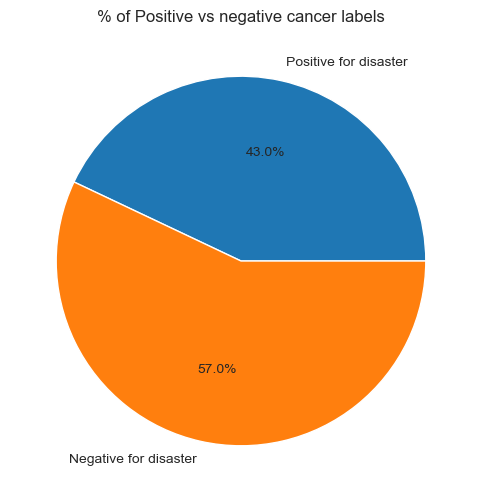

id                                                                                                                                           10169
keyword                                                                                                                            violent%20storm
location                                                                                                                                   missing
text        #stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp
target                                                                                                                                           1
Name: 7097, dtype: object
id                                                    7371
keyword                                         obliterate
location                                         Jump City
text        Dc I love you but please obliterate power girl
tar

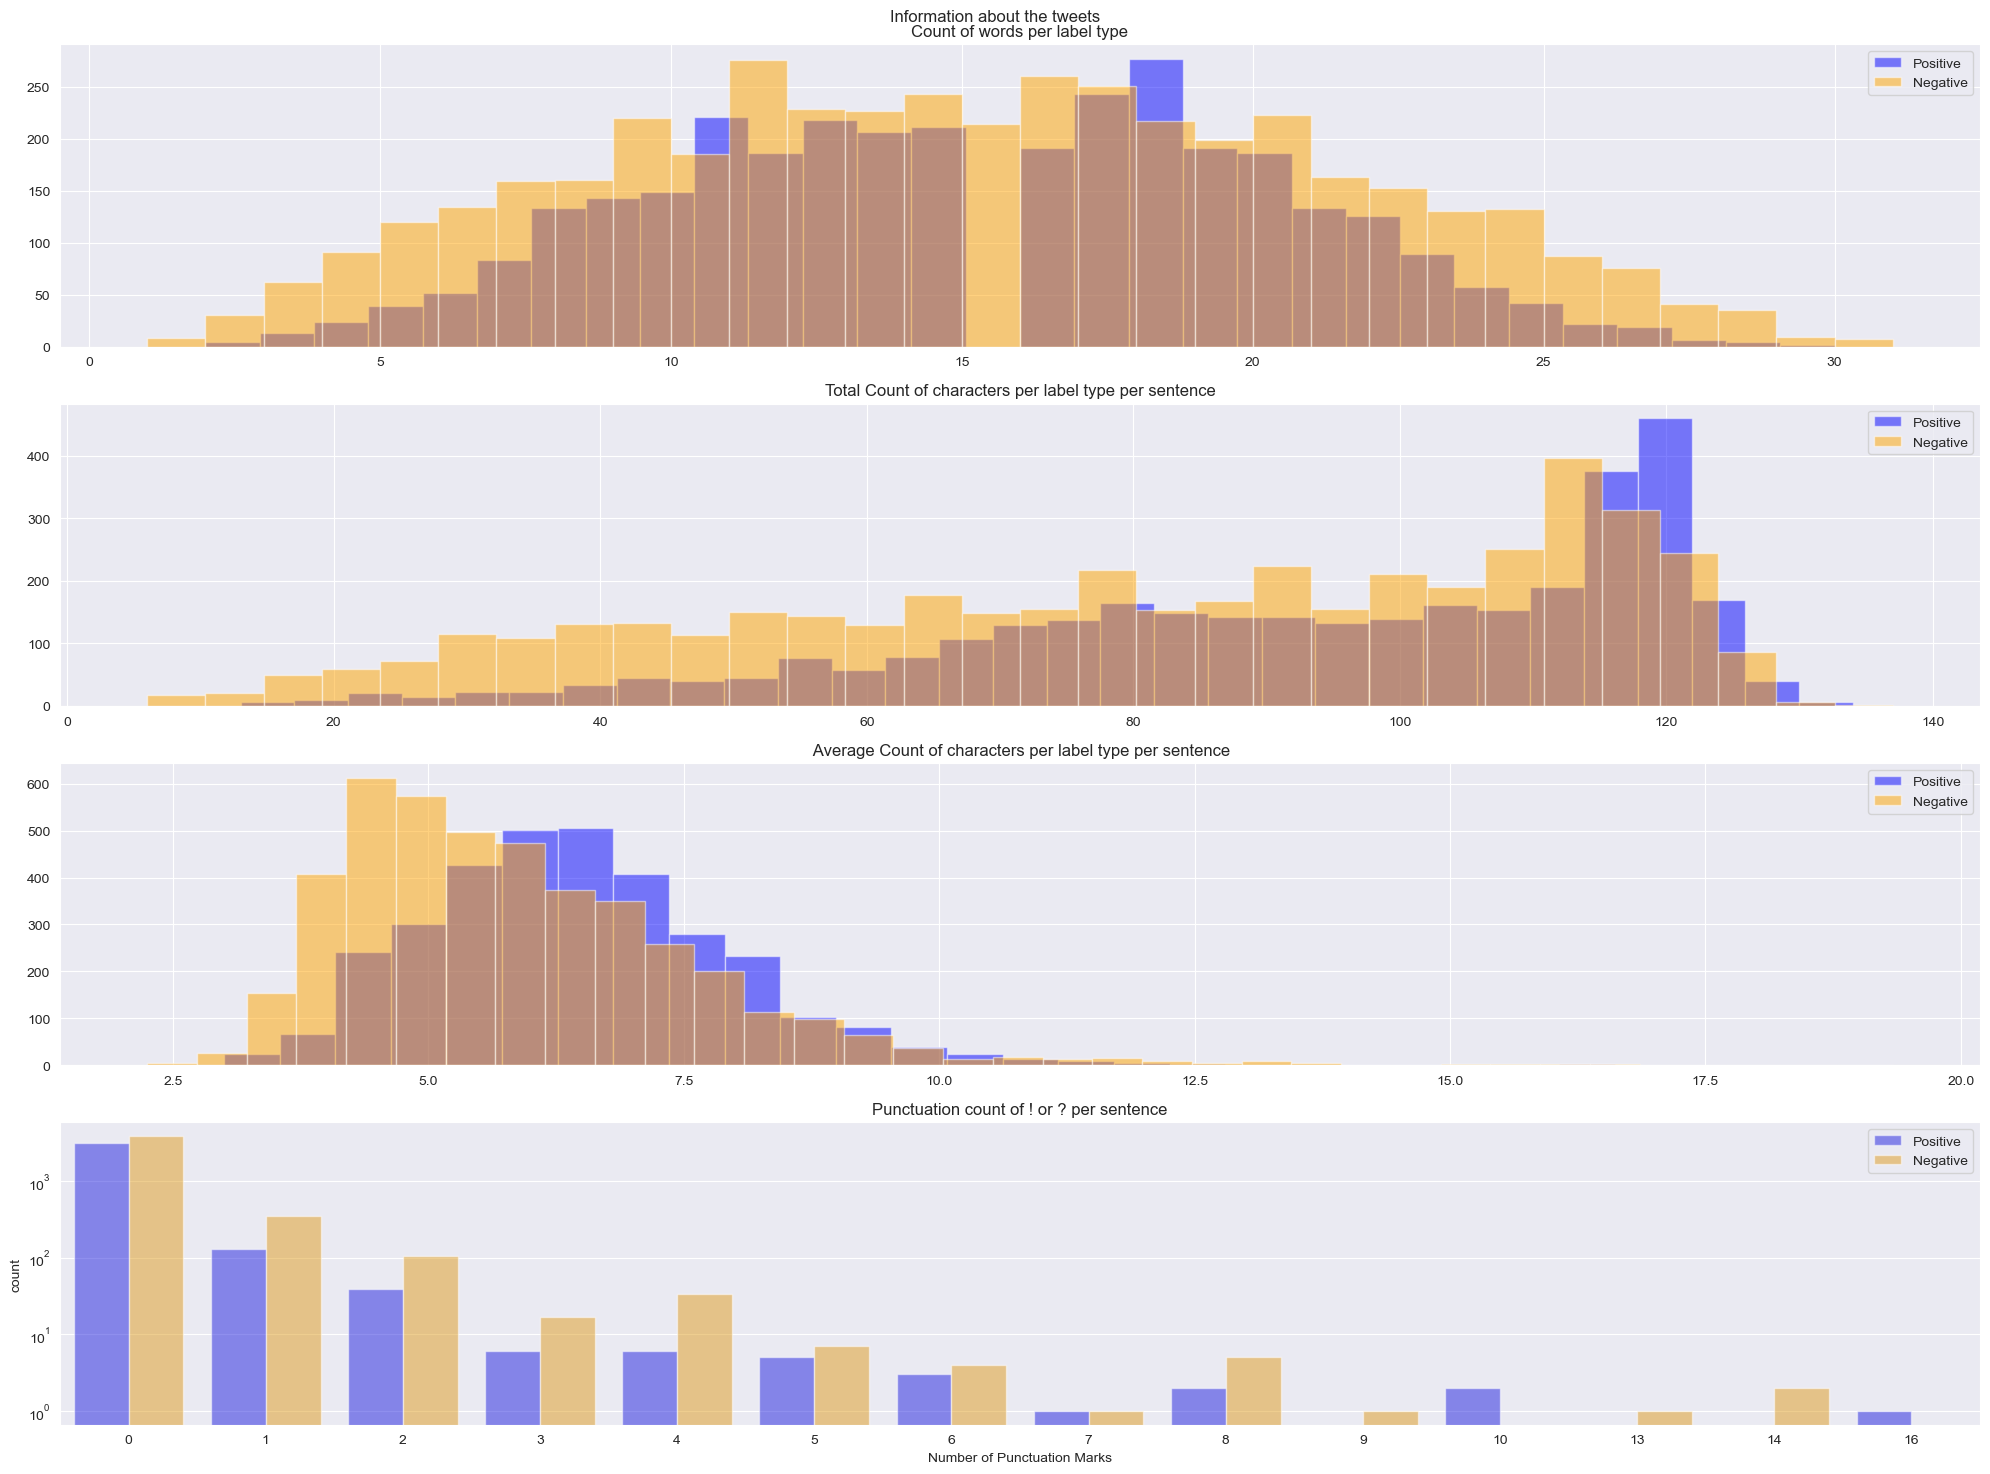

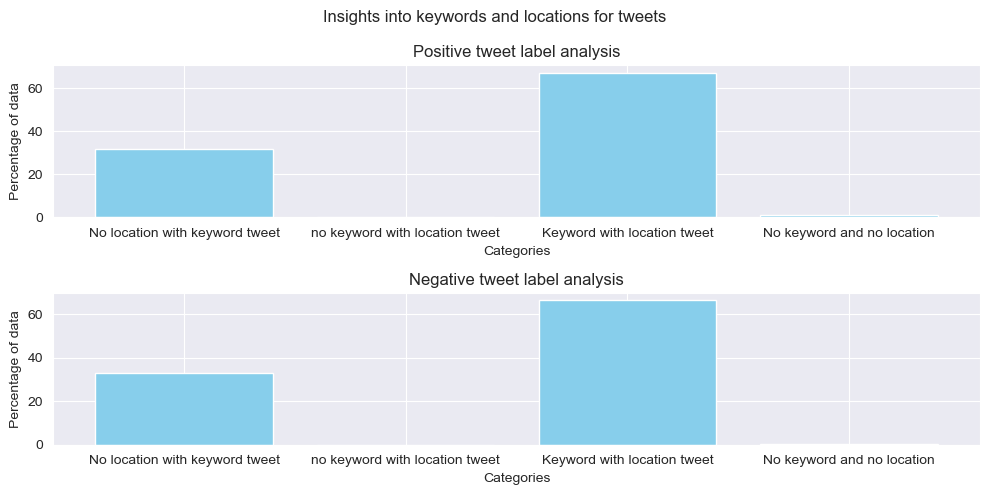

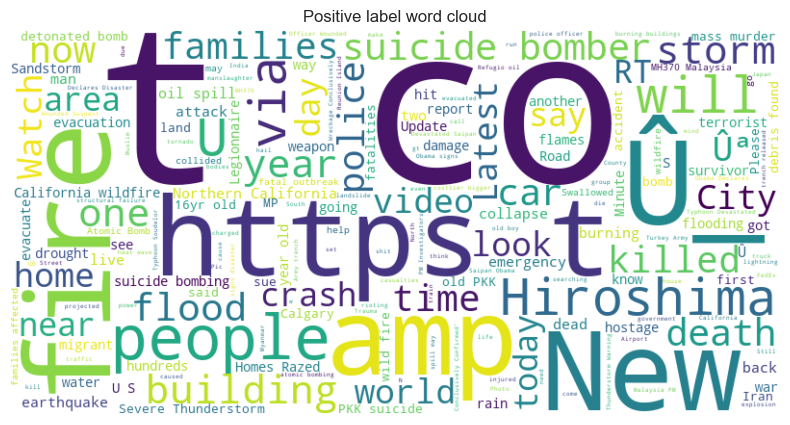

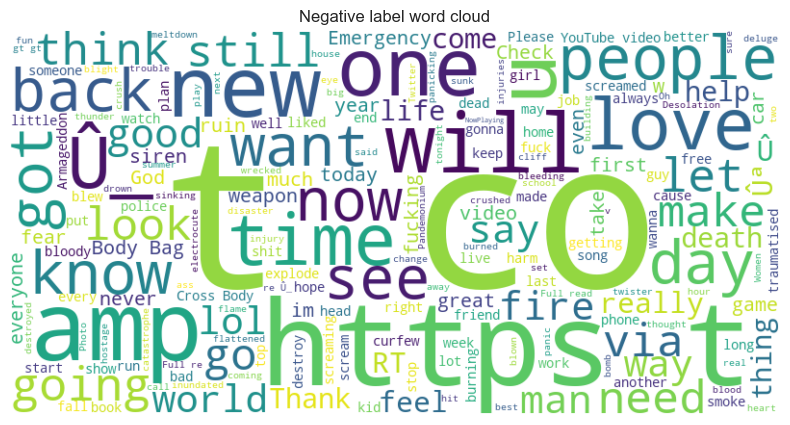

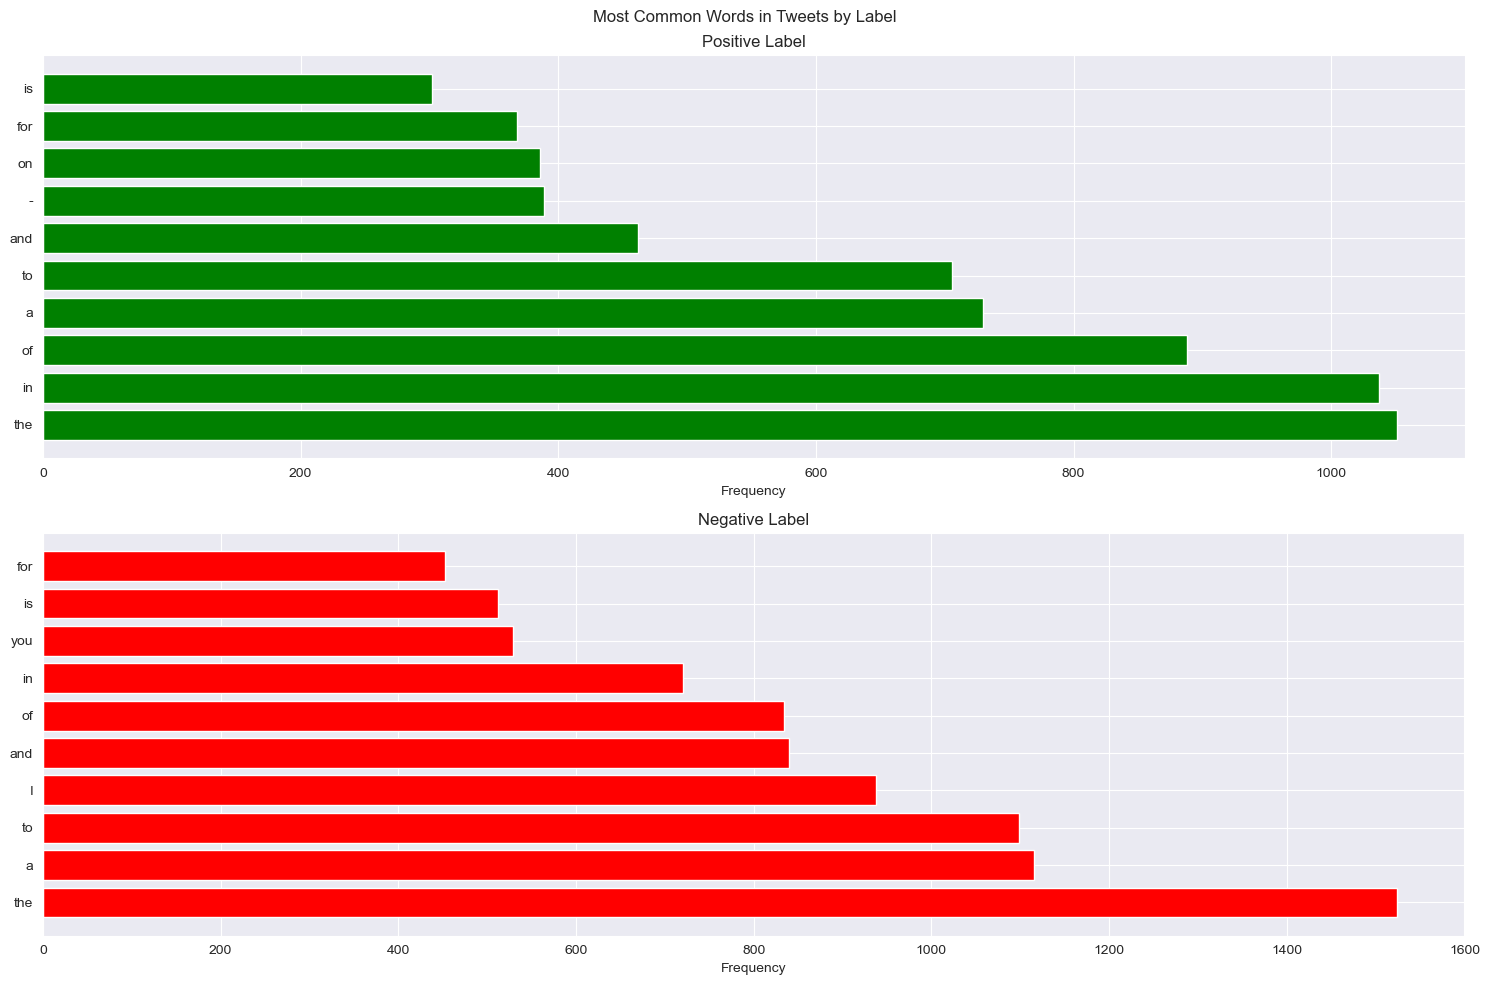

Number of unique words in positive labels: 16150
Number of unique words in negative labels: 20560


In [2]:
# Display the first 5 rows of the dataframe of the labels
print(df_train_labels.head())

# Plot the distribution of positive and negative labels in the training data with a pie chart

# Get the data
pos_per = rand_pos_set.shape[0]*100/df_train_labels.shape[0]
neg_per = rand_neg_set.shape[0]*100/df_train_labels.shape[0]
data_pie = [pos_per, neg_per]
labels = ["Positive for disaster", "Negative for disaster"]

# do the plotting
sns.set_style("darkgrid")
plt.figure(figsize=(6,6))
plt.pie(data_pie, labels = labels, autopct='%1.1f%%')
plt.title('% of Positive vs negative cancer labels')
plt.show()

# Show an example of an tweet with a negative and a positive label
pd.set_option('display.max_colwidth', None)

# 2. Show all rows (fixes the dots in the middle of the DataFrame)
pd.set_option('display.max_rows', None)

# 3. Show all columns (optional, if you have many columns)
pd.set_option('display.max_columns', None)
print(rand_pos)
print(rand_neg)

# Do descriptive stats on the texts of the tweets like mean, median and mode of the number of words for disaster vs non disaster tweets
pos_word_number = []
neg_word_number = []
pos_character_number = []
neg_character_number = []
pos_avg_word_length = []
neg_avg_word_length = []
pos_punc_length = []
neg_punc_length = []
# count number of letters and also number of words
# will separate number of words by just a space
for sentence in rand_pos_set.loc[:, 'text']:
    positive_sentences = []
    positive_sentences.append(sentence)
    pos_word_number.append(len(positive_sentences[0].split()))
    pos_character_number_word = []
    exclam = sentence.count('!')
    exclam_3 = sentence.count('!!!')
    interrogation = sentence.count('\?')
    puncuation = exclam + interrogation + exclam_3
    pos_punc_length.append(puncuation)
    for character in sentence.split():
        pos_character_number_word.append(len(list(character)))
    pos_character_number.append(sum(pos_character_number_word))
    pos_avg_word_length.append(sum(pos_character_number_word)/len(pos_character_number_word))
for sentence in rand_neg_set.loc[:, 'text']:
    negative_sentences = []
    negative_sentences.append(sentence)
    neg_word_number.append(len(negative_sentences[0].split()))
    neg_character_number_word = []
    exclam = sentence.count('!')
    exclam_3 = sentence.count('!!!')
    interrogation = sentence.count('\?')
    puncuation = exclam + interrogation + exclam_3
    neg_punc_length.append(puncuation)
    for character in sentence.split():
        neg_character_number_word.append(len(list(character)))
    neg_character_number.append(sum(neg_character_number_word))
    neg_avg_word_length.append(sum(neg_character_number_word)/len(neg_character_number_word))
# Create dataframes out of the list of word numbers to do some descriptive stats on them
pos_word_number_df = pd.DataFrame(pos_word_number)
neg_word_number_df = pd.DataFrame(neg_word_number)
pos_char_number_df = pd.DataFrame(pos_character_number)
neg_char_number_df = pd.DataFrame(neg_character_number)
pos_char_avg_number_df = pd.DataFrame(pos_avg_word_length)
neg_char_avg_number_df = pd.DataFrame(neg_avg_word_length)
pos_punct_number_df = pd.DataFrame(pos_punc_length)
neg_punct_avg_number_df = pd.DataFrame(neg_punc_length)
# Do the descriptive stats
print(f" Description of positive word counts {pos_word_number_df.describe()}")
print(f" Description of negative word counts {neg_word_number_df.describe()}")

# DO a histogram of word counts for negative and positive labels as well as character count
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20, 15))
fig.suptitle('Information about the tweets')
# Plot the first histogram with a label and transparency
ax1.hist(pos_word_number_df, alpha=0.5, label='Positive', color='blue', bins=30)
# Plot the second histogram on the same figure
ax1.hist(neg_word_number_df, alpha=0.5, label='Negative', color='orange', bins=30)
ax1.set_title('Count of words per label type')
ax1.legend(loc='best')

# DO a histogram of character count for negative and positive labels
# Plot the first histogram with a label and transparency
ax2.hist(pos_char_number_df, alpha=0.5, label='Positive', color='blue', bins=30)
# Plot the second histogram on the same figure
ax2.hist(neg_char_number_df, alpha=0.5, label='Negative', color='orange', bins=30)
ax2.set_title('Total Count of characters per label type per sentence')
ax2.legend(loc='best')

# DO a histogram of average character count for negative and positive labels
# Plot the first histogram with a label and transparency
ax3.hist(pos_char_avg_number_df, alpha=0.5, label='Positive', color='blue', bins=30)
# Plot the second histogram on the same figure
ax3.hist(neg_char_avg_number_df, alpha=0.5, label='Negative', color='orange', bins=30)
ax3.set_title(' Average Count of characters per label type per sentence')
ax3.legend(loc='best')

# DO a histogram of punctuation count for negative and positive labels per sentence
# Plot the first histogram with a label and transparency
import seaborn as sns
# Combine data for Seaborn
df_pos = pd.DataFrame(pos_punct_number_df).assign(Label='Positive')
df_pos.columns = ['count', 'Label'] # Rename columns for clarity

df_neg = pd.DataFrame(neg_punct_avg_number_df).assign(Label='Negative')
df_neg.columns = ['count', 'Label']
# Combine into one "Long Format" dataframe
combined_punct_df = pd.concat([df_pos, df_neg])
sns.countplot(
    data=combined_punct_df, 
    x='count', 
    hue='Label', 
    palette={'Positive': 'blue', 'Negative': 'orange'},
    alpha=0.5,
    ax=ax4 # Draw on the specific subplot
)
ax4.set_title('Punctuation count of ! or ? per sentence')
ax4.set_yscale('log')
ax4.set_xlabel('Number of Punctuation Marks')
ax4.legend(loc='upper right')
plt.tight_layout()

#Calculate percentage of positive labels with keyword and no location and percentage with no location but with keyword, and percentage with both
# do this for both positive and negative labels and put them in a 1x2 subplot\
total_pos =  df_train_labels[df_train_labels.target == 1].shape[0]
total_neg =  df_train_labels[df_train_labels.target == 0].shape[0]

no_loc_with_keyword = df_train_labels[
    (df_train_labels.loc[:, 'keyword'] != 'missing') & 
    (df_train_labels.loc[:, 'location'] == 'missing')
    ]

no_keyword_with_location = df_train_labels[
    (df_train_labels.loc[:, 'keyword'] == 'missing') & 
    (df_train_labels.loc[:, 'location'] != 'missing')
    ]

keyword_with_location = df_train_labels[
    (df_train_labels.loc[:, 'keyword'] != 'missing') & 
    (df_train_labels.loc[:, 'location'] != 'missing')
    ]

no_keyword_with_no_location = df_train_labels[
    (df_train_labels.loc[:, 'keyword'] == 'missing') & 
    (df_train_labels.loc[:, 'location'] == 'missing')
    ]

# Get the data
pos_info= [no_loc_with_keyword[no_loc_with_keyword.target == 1].shape[0]*100/total_pos,
          no_keyword_with_location[no_keyword_with_location.target == 1].shape[0]*100/total_pos,
          keyword_with_location[keyword_with_location.target == 1].shape[0]*100/total_pos,
          no_keyword_with_no_location[no_keyword_with_no_location.target == 1].shape[0]*100/total_pos
          ]
neg_info= [no_loc_with_keyword[no_loc_with_keyword.target == 0].shape[0]*100/total_neg,
          no_keyword_with_location[no_keyword_with_location.target == 0].shape[0]*100/total_neg,
          keyword_with_location[keyword_with_location.target == 0].shape[0]*100/total_neg,
          no_keyword_with_no_location[no_keyword_with_no_location.target == 0].shape[0]*100/total_neg
          ]
labels = ["No location with keyword tweet", "no keyword with location tweet",
          "Keyword with location tweet", "No keyword and no location"]

# do the plotting
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 5))
fig.suptitle('Insights into keywords and locations for tweets')
sns.set_style("darkgrid")
ax1.bar(labels, pos_info, color='skyblue')
ax1.set_title('Positive tweet label analysis')
ax1.set_xlabel("Categories")
ax1.set_ylabel("Percentage of data")
sns.set_style("darkgrid")
ax2.bar(labels, neg_info, color='skyblue')
ax2.set_title('Negative tweet label analysis')
ax2.set_xlabel("Categories")
ax2.set_ylabel("Percentage of data")
plt.tight_layout()

# Create word cloud for negative and positive labels
from wordcloud import WordCloud
# gather positive and negative text
# and put all of the text together for word cloud analysis
pos_text = df_train_labels[df_train_labels.target == 1].text.str.cat(sep=' ')
neg_text = df_train_labels[df_train_labels.target == 0].text.str.cat(sep=' ')

# Create the word cloud objects
pos_word_cloud = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
neg_word_cloud = WordCloud(width=800, height=400, background_color='white').generate(neg_text)

plt.figure(figsize=(10, 5))
plt.title("Positive label word cloud")
plt.imshow(pos_word_cloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Negative label word cloud")
plt.imshow(neg_word_cloud, interpolation='bilinear')
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()

# plot a histogram of the most common words in positive and negative labels
from collections import Counter
# Tokenize the text into words
pos_words = pos_text.split()
neg_words = neg_text.split()    
# Count the frequency of each word
pos_word_counts = Counter(pos_words)
neg_word_counts = Counter(neg_words)
# Get the most common words
most_common_pos = pos_word_counts.most_common(10)
most_common_neg = neg_word_counts.most_common(10)
# Separate words and their counts for plotting
pos_words, pos_counts = zip(*most_common_pos)
neg_words, neg_counts = zip(*most_common_neg)
# Plotting
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))
fig.suptitle('Most Common Words in Tweets by Label')
# Positive words
ax1.barh(pos_words, pos_counts, color='green')
ax1.set_title('Positive Label')
ax1.set_xlabel('Frequency')
# Negative words
ax2.barh(neg_words, neg_counts, color='red')
ax2.set_title('Negative Label')
ax2.set_xlabel('Frequency')
plt.tight_layout()
plt.show()
# count the number of unique words in positive and negative labels

print(f"Number of unique words in positive labels: {len(pos_word_counts)}")
print(f"Number of unique words in negative labels: {len(neg_word_counts)}")

# DModel Architecture and Data cleaning

* Steps to clean the text data: 
    * For data cleaning, I am creating a new field within all of the training data that factors in keyword, location and tweet text data into one, and I am also removing web addresses and html tag information that do not contribute to the training and classification process
    * As it relates to how I plan to **vectorize** the data, I did the following:
        * Used keras vectorizing function with max len of 75. I checked and the maximum number of words from the training and validation data are 20 and 23 respectively, so I am picking 75 since it is higher than the maximum number I observed and adds padded 0s for the cases in which the tweet is below the maximum number of tokens
        * For the maximum number of tokens, I found that the maximum number of unique words in the positive labels is 16150 and for negative is 20560, so I am setting the maximum number to be 15,000 which should account for misspellings as well as differences caused by lower and upper case as well as punctuations without spaces
        * No need to specify further data cleaning since I have already done that and also created a new column within the train and validation data that factors in for location and keyword data
        * This method consists of a preprocessing layer that maps text features into integer sequences and enforces the max token and max len restrictions previously described. I believe this will work because it creates a numeric representation of the tokens of the data and places the previously mentioned restrictions. The model can now associate this numeric representation with whether the `tweet` is a disaster tweet or not
    * As it relates to model **architecture**, I plan to have the following:
        * I plan to have an embedding layer. This is important because the vectorizations step just assigns integers to words. This data needs further processing to prevent the model from making false assumptions. This **embedding** step matches each integer to a dense vector (a list of floating point numbers) that represents the meaning of the word, and this `meaning` is what the model learns and trains for; so the **embedding** step is extremely useful because it creates a matrix of each unique word within my model for each row, and the column represents the features associated with this word, which would help the model learn the meaning of each word and whether it should be associated with disaster or not. So this embedding is useful for the model because LSTMS classify based on the entire sequence of words, but word embedding also allows the model to assign meaning to each word token we have in the model that we are choosing to classify. Note that I plan to use an input dimension of max number of tokens + 1 to account for 0 padding and output dimension of `128`, but I may change the output dimension based on model performance.
        * One bidirectional LSTM layer, which has the following effect:
            * LSTMs get rid of the vanishing and exploding gradient problem that RNNs introduce
            * The bidirectional nature of this architecture extends the LSTM by processing the tweet sequences in both forward and backward directions by using two LSTM layers, which allows the model to past and future context within a tweet, which is helpful when performing this disaster classification since the entire context of the tweet is important to make a prediction since a word like `fire` may change the nature of the tweet depending on the context; for instance, `that was a fire concert`, which is not a disaster vs `there is a fire in the forest!`, which would be classified as a disaster. Also bidirectional LSTMs are very useful with classification tasks, but not as useful with forecasting, but this challenge is about classification!
            * I will use drop out in the LSTM layer to prevent overfitting the training data, I will start with droput at 50% and increase/decrease depending on model performance
            * I will also start with `64 units` within the LSTM and potentially increase/decrease based on model performance
            * `Number of dense layers` to use after LSTM. I will start with one, but I may try 2 to see if it improves model performance




 ## Split the Data

In [3]:
import keras
from keras import layers
# Initial split of the data to support the model training
training_set, validation_set = divide_input_data(df_train_labels)

# do some data cleaning on the text data like lowercasing, removing urls, special characters, etc.
# after the cleaning, the training process should use the new created column of cleaned_text
train_to_use = clean_input_data(training_set, shuffle=True)
validation_to_use = clean_input_data(validation_set, shuffle=True)

# vectorize the data so that it works with pytorch backend
# create the vectorize layer
MAX_TOKENS = 15000
MAX_LEN = 75
vectorize_layer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=MAX_LEN
)

# adapt the vectorization layer to the training data
vectorize_layer.adapt(train_to_use['cleaned_text'].values.tolist())

# obtain the X_train, X_val, y_train, y_val for model training
# convert to numpy arrays for model training and get rid of pandas indexing
X_train = vectorize_layer(train_to_use['cleaned_text'].values.tolist())
y_train = train_to_use['target'].values.astype('float32')
X_val = vectorize_layer(validation_to_use['cleaned_text'].values.tolist())
y_val = validation_to_use['target'].values.astype('float32')

max_row_train = train_to_use.loc[train_to_use['cleaned_text'].str.len().idxmax()]
print(len(max_row_train.cleaned_text.split()))
max_row_val = validation_to_use.loc[validation_to_use['cleaned_text'].str.len().idxmax()]
print(len(max_row_val.cleaned_text.split()))

23
20


## Build the different models

In [54]:
# build the different models using keras
import keras
from keras import layers

def tweet_classify_model(x_train, LSTM_units=64, embedding_dim=128, dropout_rate=0.5, MAX_TOKENS = 15000,MAX_LEN=75, model_type='complex'):
    """This function builds a deep learning model for tweet classification using LSTM layers.
    It allows the user to set the following hyperparameters: LSTM_units, embedding_dim, and dropout_rate. Note that this also needs the training data to
    adapt the vectorization layer."""

    # Actually build the model now
    if model_type == 'simple':
        model = keras.Sequential([
            # Input layer
            # needed to make some changes here to add vectorization layer outside of the model
            # because of issues with pytorch backend
            layers.Input(shape=(MAX_LEN,), dtype='int64'),
            
            # Embedding layer
            layers.Embedding(input_dim=MAX_TOKENS + 1, output_dim=embedding_dim),

            # add the LSTM layer
            layers.Bidirectional(layers.LSTM(LSTM_units, dropout=dropout_rate)),
            # layers.Bidirectional(layers.LSTM(LSTM_units)),
            # adding dropout for regularization before going to dense layers to prevent overfitting within the dense layer
            # layers.Dropout(dropout_rate),
            # Adding the dense layers with leaky relu activations
            layers.Dense(1, activation='sigmoid')
        ])
        return model
    elif model_type == 'complex':
        model = keras.Sequential([
            # Input layer
            # needed to make some changes here to add vectorization layer outside of the model
            # because of issues with pytorch backend
            layers.Input(shape=(MAX_LEN,), dtype='int64'),
            
            # Embedding layer
            layers.Embedding(input_dim=MAX_TOKENS + 1, output_dim=embedding_dim),
            
            # adding dropout after embedding layer for regularization
            # layers.Dropout(dropout_rate),

            # add the LSTM layer, make sure it is bidirectional
            # note that dropout is added within the LSTM layer to prevent overfitting within the LSTM layers to begin with
            layers.Bidirectional(layers.LSTM(LSTM_units, dropout=dropout_rate)),
            # adding dropout for regularization before going to dense layers to prevent overfitting within the dense layer
            # layers.Dropout(dropout_rate),
            # Adding the dense layers with leaky relu activations
            # halves the number of neurons from LSTM from 256 to 128
            # layers.Dense(4, kernel_regularizer=keras.regularizers.L2(0.05)),
            # layers.LeakyReLU(negative_slope=0.1),
            # layers.Dropout(dropout_rate),
            layers.Dense(8, kernel_regularizer=keras.regularizers.L2(0.01)),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dropout(dropout_rate),
            layers.Dense(1, activation='sigmoid')
        ])
        return model
    else:
        return "Model type not recognized. Please use 'simple' or 'complex'."

# Compile the different models

In [55]:
# Build the models
simple_model = tweet_classify_model(X_train, dropout_rate=0.9, model_type='simple', LSTM_units=32, embedding_dim=64)
complex_model = tweet_classify_model(X_train, dropout_rate=0.9, model_type='complex', LSTM_units=32, embedding_dim=64)

# Compile the models
simple_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                     loss='binary_crossentropy',
                     metrics=['accuracy',
                              keras.metrics.Precision(),
                              keras.metrics.Recall()])
complex_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
                      loss='binary_crossentropy',
                      metrics=['accuracy',
                               keras.metrics.Precision(),
                               keras.metrics.Recall()])

# Show the summary of the different models
simple_model.summary()
complex_model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 75, 64)         │       960,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984,961 (3.76 MB)

 Trainable params: 984,961 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ (None, 75, 64)         │       960,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_33                │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,425 (3.76 MB)

 Trainable params: 985,425 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

## Train the simple model

In [56]:
# Make sure to build infrastructure to save the model so you can re-use and generate confusion matrix
# Set up model checkpointing, do the training, plot confusion matrix
# Also figure out how to use tensorboard to monitor the training process
# Also need to add early stopping to prevent overfitting
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
import datetime

# Define the callbacks
# start with early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

# model checkpoint callback in order to save the best model to disk
# get datetime for unique naming of the model files
now = datetime.datetime.now()
date_time = now.strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = f'simple_model_best_{date_time}.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1)
# Tensor board callback to monitor training
log_dir = f"logs/simple_model/{date_time}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# do the training with all of the callbacks
# start with simple training loop to see how it goes
history_simple = simple_model.fit(X_train, y_train,
                                  epochs=30,
                                  batch_size=512,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

# print best model validation accuracy and loss for complex model
best_epoch = np.argmin(history_simple.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Validation Loss at best epoch: {history_simple.history['val_loss'][best_epoch]}")
print(f"Validation Accuracy at best epoch: {history_simple.history['val_accuracy'][best_epoch]}")

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5722 - loss: 0.6773 - precision_32: 0.5388 - recall_32: 0.1759
Epoch 1: val_loss improved from None to 0.57222, saving model to simple_model_best_20251225-111442.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step - accuracy: 0.6164 - loss: 0.6556 - precision_32: 0.6822 - recall_32: 0.2010 - val_accuracy: 0.7630 - val_loss: 0.5722 - val_precision_32: 0.7566 - val_recall_32: 0.6606
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7615 - loss: 0.5329 - precision_32: 0.7237 - recall_32: 0.7322
Epoch 2: val_loss improved from 0.57222 to 0.46557, saving model to simple_model_best_20251225-111442.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - accuracy: 0.7757 - loss: 0.4995 - precision_32: 0.7603 - recall_32: 0.6981 - val_accuracy: 0.7866 - val_loss: 0.4656 - val_precision_32: 0.8553 - val_recall_32: 0.6055
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8308 - loss: 0.4113 - precision_32: 0.847

## Train the complex model

In [57]:
# Do the same for the complex model now

# Define the callbacks
# start with early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

# model checkpoint callback in order to save the best model to disk
# get datetime for unique naming of the model files
now = datetime.datetime.now()
date_time = now.strftime("%Y%m%d-%H%M%S")
checkpoint_filepath = f'complex_model_best_{date_time}.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1)
# Tensor board callback to monitor training
log_dir = f"logs/complex_model/{date_time}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# do the training with all of the callbacks
history_complex = complex_model.fit(X_train, y_train,
                                  epochs=30,
                                  batch_size=512,
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping, model_checkpoint, tensorboard_callback])

# print best model validation accuracy and loss for complex model
best_epoch = np.argmin(history_complex.history['val_loss'])
print(f"Best epoch: {best_epoch + 1}")
print(f"Validation Loss at best epoch: {history_complex.history['val_loss'][best_epoch]}")
print(f"Validation Accuracy at best epoch: {history_complex.history['val_accuracy'][best_epoch]}")

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.5512 - loss: 0.8025 - precision_33: 0.4332 - recall_33: 0.1464
Epoch 1: val_loss improved from None to 0.71294, saving model to complex_model_best_20251225-111538.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 390ms/step - accuracy: 0.5562 - loss: 0.7739 - precision_33: 0.4317 - recall_33: 0.1039 - val_accuracy: 0.5706 - val_loss: 0.7129 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5655 - loss: 0.7082 - precision_33: 0.2823 - recall_33: 0.0031
Epoch 2: val_loss improved from 0.71294 to 0.67374, saving model to complex_model_best_20251225-111538.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - accuracy: 0.5695 - loss: 0.6989 - precision_33: 0.2727 - recall_33: 0.0011 - val_accuracy: 0.5706 - val_loss: 0.6737 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.5691 - loss: 0.6771 - p

# Result and Analysis

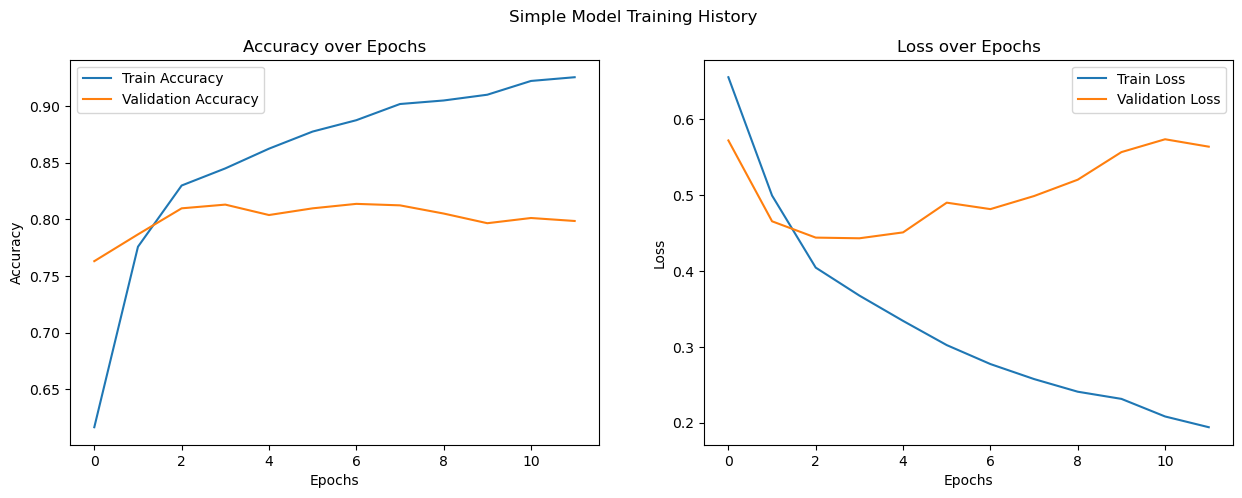

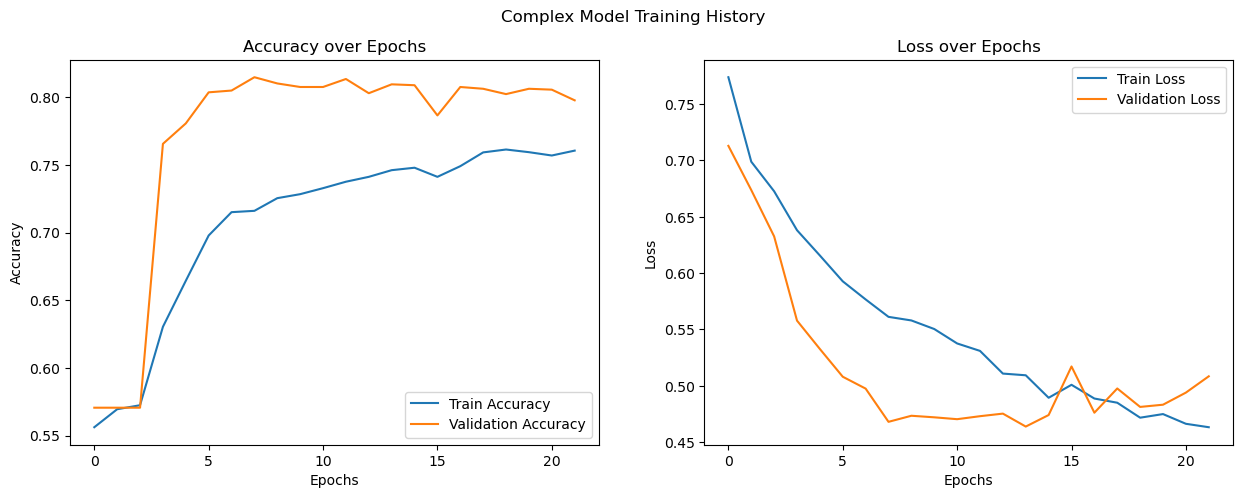

In [66]:
# Plot the accuracy and loss curves for both models
import matplotlib.pyplot as plt
# Simple model plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Simple Model Training History')
# Accuracy plot
ax1.plot(history_simple.history['accuracy'], label='Train Accuracy')
ax1.plot(history_simple.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Accuracy over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
# Loss plot
ax2.plot(history_simple.history['loss'], label='Train Loss')
ax2.plot(history_simple.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
# complex model plots
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Complex Model Training History')
# Accuracy plot
ax3.plot(history_complex.history['accuracy'], label='Train Accuracy')
ax3.plot(history_complex.history['val_accuracy'], label='Validation Accuracy')
ax3.set_title('Accuracy over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.legend()
# Loss plot
ax4.plot(history_complex.history['loss'], label='Train Loss')
ax4.plot(history_complex.history['val_loss'], label='Validation Loss')
ax4.set_title('Loss over Epochs')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
ax4.legend()

# # 1. Load the TensorBoard extension to see how the simple model performed
# %load_ext tensorboard

# # 2. Launch TensorBoard (pointing to your logs folder)
# %tensorboard --logdir logs/simple_model

# # Then do the same for the complex model

# # 1. Load the TensorBoard extension to see how the simple model performed
# %load_ext tensorboard

# # 2. Launch TensorBoard (pointing to your logs folder)
# %tensorboard --logdir logs/complex_model

## Running the model with the testing data

In [65]:
# Prepare the test data for predictions
# need to clean the test data just like I did for the training and validation data
test_df = clean_input_data(df_test_labels, shuffle=False)
# Vectorize the test data
X_test = vectorize_layer(test_df['cleaned_text'].values.tolist())
# Run Predictions
print(f"Running predictions on {len(test_df)} tweets...")
predictions = complex_model.predict(X_test, verbose=1)

# Format for Submission
# The 'predictions' array will be probabilities (0.0 to 1.0). 
# We need to map these back to the tweet IDs for submission.
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = (predictions.flatten() > 0.5).astype(int) # Convert [[0.1], [0.9]] to [0.1, 0.9]

# 6. Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

# Peek at the first few rows
print(submission.head())

Running predictions on 3263 tweets...
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step
Submission file saved as 'submission.csv'.
   id  target
0   0       0
1   2       0
2   3       1
3   9       1
4  11       1


 ## Analysis of the Plots and Figures

By looking at the performance of the simple model, I have the following key observations that helped with the design of the more complex model:
* The complex model does not have any meaningfully improved loss and accuracy numbers. This may be due to the added dense layer at the end, but I do not think the extra complexity is worth it, so I will be using the simple model to evaluate the testing data
* It also seems like both of my models are overfitting the data because even though I have a dropout rate as high as 0.9, the validation loss plateaus while the training loss keeps on decreasing. Therefore, a better strategy may have been to leverage transfer learning and use a previously trained model with some small modifications to work for this dataset
* Additionally, this dataset may not be big enough to prevent overfitting of the data with the models I have
* I started with a dropout rate with 0.5, but had to increase it to 0.9 to reduce overfitting
* I am using a learning rate of `1-e2`, but tried with `1e-1` and `1e-4`, which are too high and low respectively for the models
* The complex model has en extra dense layer, but I do not think this makes much of a difference
* Both models use a bidirectional LSTM with the same number of neurons, which I think is the core part of the model that allows both of them to achieve the accuracy that they are able to achieve. The bidirectional nature of the LSTM allows the tweet classification to be made based on the full context of the tweet, which is very important for the performance of the model

For the reasons shared above, I think the more complex model performs better.

Also, a couple of things did not work well:
* Bigger dense layers at the end of the model would actually cause overall accuracy to decrease, and I think it is because I do not have enough training data to be able to train a bigger dense layer at the end of the model
* Both models start overfitting the data even though the dropout rate is 0.9 in both cases, so in the future, it may be better to leverage transfer learning or create a model with a smaller dense layer, LSTM units and embedding layer to prevent overfitting

A couple of things incredibly helped with the performance of the model:
* Adding dropout layers to prevent overfitting
* Using bidirectional LSTM. I used a non-bidirectional LSTM in earlier versions of the model, and it worked much worse than the bidirectional one


# Conclusion

Results with the test data: 
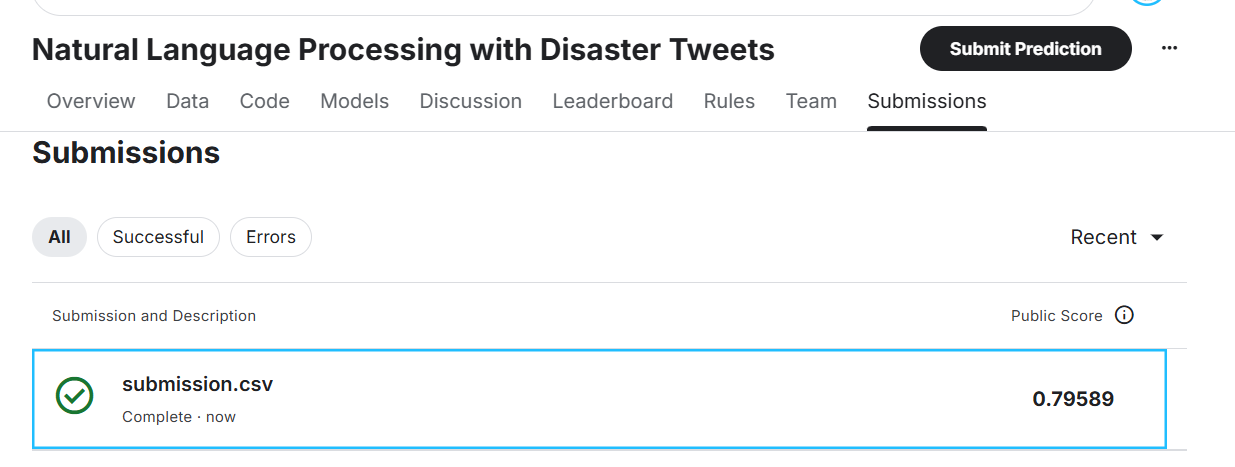

Results interpretation: 
* Models are overfitting the data, and there is no need to add extra dense layers at the end of the model. 
* To have better performance, it may be better to either do transfer learning or use a bigger training dataset

Things that did not help the model learning:
* Increasing the dense layer size or adding extra dense layers at the end of the model did not improve validation accuracy and losses because it was causing the model to overfit the data 

Thing to potentially try in the future to improve model performance: 
* Use transfer learning or another type of RNN that works better with this data or increase training data size

## Links

This code can be found in: https://github.com/Adalberto-Machin/Week-4-Kaggle-disaster-tweet-competition